# Introduction

In Lesson 1, *Anomaly Detection: Introduction*, we learned that anomalies are outliers in the data that merit further scrutiny. We discussed basic scoring methods to identify outliers.

We will continue our discussion by looking for outliers in one-dimensional (univariate) data. We will use both the z-score and modified z-score. We will examine the strengths and limitations of both approaches.

# Learning Outcomes

You should walk away from this Python tutorial with:
1. An understanding of anomaly detection as an algorithm
2. An appreciation of the importance of choosing an appropriate model for the data by which to judge what is normal and what could be an anomaly
3. Some practical experience in using z-score and modified z-score in anomaly detection

# Imports

In [ ]:
%matplotlib inline

import sys
import scipy
import scipy.stats as ss
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import random

# Python & Library Versions

In [2]:
packages = [matplotlib, np, pd, scipy]

msg = f"""
Python Version: {sys.version}

library .      version
-------        -------"""
print(msg)

for package in packages:
    print(f"{package.__name__:11}    {package.__version__:>7}")


Python Version: 3.9.10 (v3.9.10:f2f3f53782, Jan 13 2022, 16:55:46) 
[Clang 13.0.0 (clang-1300.0.29.30)]

library .      version
-------        -------
matplotlib       3.8.3
numpy           1.26.4
pandas           2.2.0
scipy           1.12.0


---

# Section 1: Overview of Anomaly Detection

In this lesson, we will use the z-score and modified z-score to detect anomalies in real-world data. Initially, we will use a dataset where anomaly detection works relatively smoothly. Then, as an exercise, you will work with a dataset where more judgment is required to learn about some of the challenges associated with the z-score and modified z-score. 

### The workflow

As we discussed in the lecture, this is workflow:

    - Make a model for your data
    - Choose a scoring method
    - Choose a cutoff above/below which the points are anomalies
    - Look at these anomalies and see if the analysis makes sense

*CAUTION*: While exploring the data before working with it is strongly encouraged, it is inappropriate to use this exploration to decide what the cutoff should be for the scoring method. If you do this, all you will get are the outliers you have already chosen during your exploration. The modeling, scoring and cutoff choices should be made without bias.

# Section 2: Z-Score in Action—Student Participation in Standardized Testing

Let's start with an example where anomaly detection works smoothly. We'll examine student participation in standardized testing. Specifically, we will look at student participation rates in the SAT in Connecticut school districts in 2012. The raw data is available here:

https://catalog.data.gov/dataset/sat-district-participation-and-performance-2012-2013

The data was cleaned so that missing values were removed, percentages were converted into decimals and only essential data for 2012 was retained.

The goal of this section is to identify schools with low participation rates as a first step in helping these schools improve their participation rates.

Load the data as a pandas dataframe and take a look at it.

In [3]:
ct_test = pd.read_csv('SAT_CT_District_Participation_2012.csv') 
print(ct_test.shape)
ct_test.head()

(130, 2)


,District,Participation Rate
0,Ansonia,0.66
1,Avon,0.90
2,Berlin,0.81
3,Bethel,0.86
4,Bloomfield,0.81


(array([ 1.,  0.,  1.,  2.,  0.,  3.,  2.,  5.,  6.,  8.,  9., 16., 12.,
        13.,  8., 14., 15.,  8.,  5.,  2.]),
 array([0.28 , 0.316, 0.352, 0.388, 0.424, 0.46 , 0.496, 0.532, 0.568,
        0.604, 0.64 , 0.676, 0.712, 0.748, 0.784, 0.82 , 0.856, 0.892,
        0.928, 0.964, 1.   ]),
 <BarContainer object of 20 artists>)

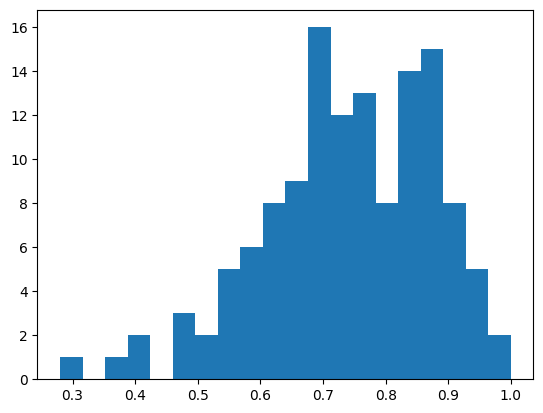

In [6]:
plt.hist(ct_test['Participation Rate'], bins=20)

There are 130 schools. For convenience we will use the index number as a numeric label for each school district and use the name when appropriate.

We are going to start by assuming that the data can be modeled with a normal distribution (we will check this later). And we will use the z-score to identify anomalies. As we are concerned about low participation rates, our cutoff will be a negative number---we are looking for schools with participation rates below the mean. Here we choose $z=-2$. That is, any school with a z-score below -2 will be labeled as an anomaly. 

If the participation rates are indeed distributed normally, then 95% of the data should be within two standard deviations of the mean. In other words, the anomalies for our threshold lie in the 2.5% left tail of the distribution. 

Note that for bigger datasets, larger absolute values of $z$ (typically $z = 3$) are often used as a threshold. Because we have a small dataset, a large value of $z$ might lead to no data being labeled as an anomaly. Also, we were conservative in our choice of $z$ because we want to help as many schools as possible. 

We could just go ahead and calculate the z-score for the participation rate, but it is good practice to look at fundamental statistics first. Let's calculate the mean and standard deviation. Since the data forms the whole population, we will report the population standard deviation (as opposed to the sample standard deviation)

In [13]:
mean_rate = ct_test['Participation Rate'].mean()

# ddof is the degrees of freedom correction 
# in the calculation of the standard deviation;
# for population standard deviation ddof=0
stdev_rate = ct_test['Participation Rate'].std(ddof=0)
#stdev_rate = ct_test['Participation Rate'].std()

print('Mean participation rate is {:.3f}'.format(mean_rate))
print('Standard deviation is {:.3f}'.format(stdev_rate))

Mean participation rate is 0.741
Standard deviation is 0.136


Calculate the z-score and add the result to the dataframe.

In [14]:
zscore_rate = ss.zscore(ct_test['Participation Rate'], ddof=0)
ct_test = ct_test.assign(zscore_value=zscore_rate)
ct_test.head(8)

,District,Participation Rate,zscore,zscore_value
0,Ansonia,0.66,-0.593779,-0.593779
1,Avon,0.90,1.175649,1.175649
2,Berlin,0.81,0.512113,0.512113
3,Bethel,0.86,0.880744,0.880744
4,Bloomfield,0.81,0.512113,0.512113
5,Bolton,0.85,0.807018,0.807018
6,Branford,0.77,0.217209,0.217209
7,Bridgeport,0.58,-1.183589,-1.183589


Now identify the anomalies and plot the results.

In [23]:
test = np.array([0, 1, 2, 3, 4])
index = np.array([True, True, False, True, False])
print(test[index])
print(test[~index])

[0 1 3]
[2 4]


In [17]:
def plot_anomaly(score_data, threshold):
    # Mask to plot values above and below threshold in different colors
    score_data = score_data.copy().sort_values(ascending=False).values
    ranks = np.linspace(1, len(score_data), len(score_data))
    mask_outlier = (score_data < threshold)
    print(ranks[~mask_outlier].shape, score_data[~mask_outlier].shape)
    print(ranks[mask_outlier].shape, score_data[mask_outlier].shape)
    
    
    plt.figure(dpi=150)
    plt.plot(ranks[~mask_outlier], score_data[~mask_outlier],'o', color='b',label='OK schools')
    plt.plot(ranks[mask_outlier], score_data[mask_outlier],'o', color='r', label='anomalies')
    plt.axhline(threshold,color='r',label='threshold', alpha=0.5)
    plt.legend(loc = 'lower left')
    plt.title('Z-score vs. school district', fontweight='bold')
    plt.xlabel('Ranked School district')
    plt.ylabel('Z-score')
    plt.show()

(126,) (126,)
(4,) (4,)


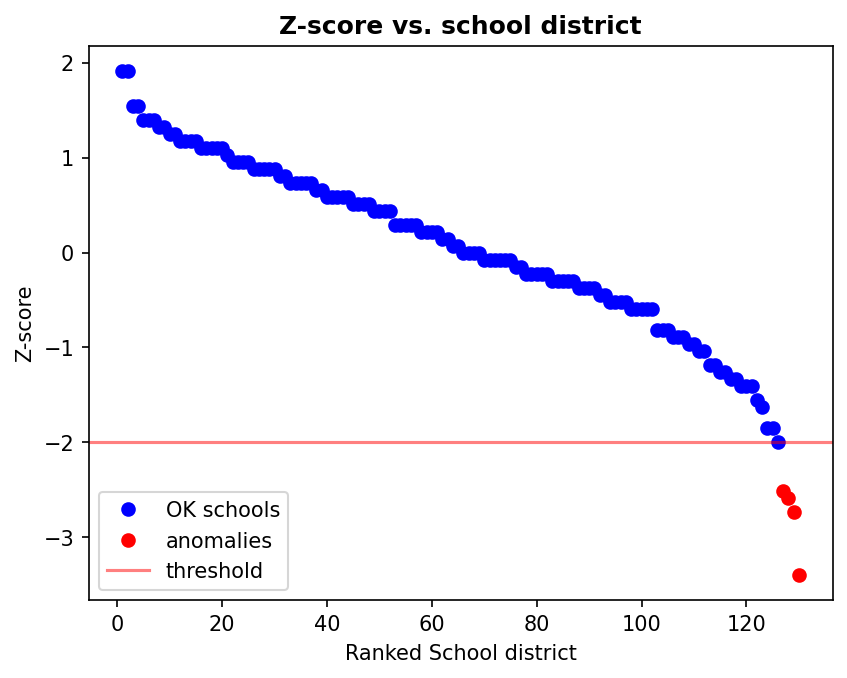

In [18]:
plot_anomaly(ct_test['zscore'], -2)

Finally, get a list of the schools that are anomalies.

In [24]:
zscore_anomalies = ct_test[(ct_test['zscore'] < -2)]
zscore_anomalies

,District,Participation Rate,zscore,zscore_value
50,New Britain,0.40,-2.510660,-2.510660
99,Windham,0.37,-2.731839,-2.731839
121,Eastern Connecticut Regional Educational Servi...,0.39,-2.584386,-2.584386
125,Stamford Academy,0.28,-3.395374,-3.395374


We have found our anomalies, but we still have one thing to do: check our assumption that the data can be modeled approximately as a normal distribution. If this is the case, then we have completed our test. If it isn't, then we cannot connect the z-score with probabilities as we did earlier in this notebook.

First, let's bin the data and see what it looks like as a histogram.

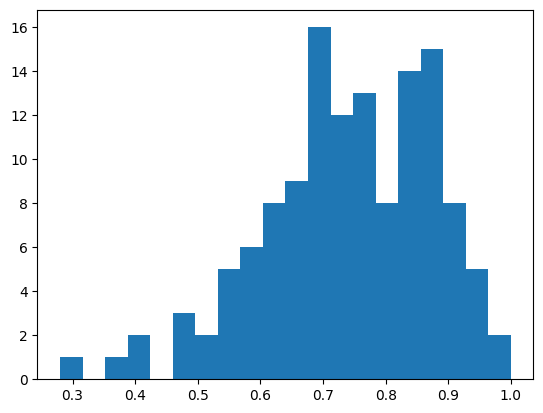

In [25]:
nbins= 20
n_hist, bins_hist, patches_hist = plt.hist(ct_test['Participation Rate'], nbins, density=False,
                           cumulative=False, linewidth=1.0, label='data')

This histogram has two maxima and is skewed left, so it is not likely to be normal. 

We can also compare the cumulative distribution function for our data with the CDF of a normal distribution with the same mean and standard deviation of our data.

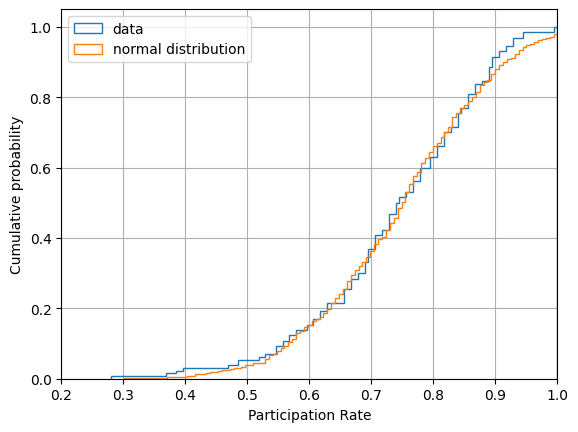

In [26]:
num_bins = 130
normal_dist = [random.gauss(mean_rate, stdev_rate) for _ in range(500)]
n, bins, patches = plt.hist(ct_test['Participation Rate'], num_bins, density=True, histtype='step',
                           cumulative=True, linewidth=1.0, label='data')
plt.hist(normal_dist, num_bins, density=True, histtype='step',
                           cumulative=True, linewidth=1.0, label='normal distribution')
plt.grid(True)
plt.legend(loc='upper left')
axes = plt.gca()
axes.set_xlim([0.2,1.0])
plt.xlabel('Participation Rate')
plt.ylabel('Cumulative probability')
plt.show()

Again, we see a difference. If these two visual tests had not been decisive, we could carry out numerical test for normality (such as the Shapiro-Wilk test).  

Even though our data is inconsistent with a normal distribution, both the z-score and the modified z-score did help us identify outliers. So while we cannot make any probabilistic claims based on the z-scores, we can confidently focus our these four schools. 

# Section 3: Z-Score vs. Modified Z-Score—World Cup Top Goal Scorers

We will now look at a dataset that shows the limitations of z-scores and why the modified z-score can be useful. 

We will at the number of goals scored by the top goalscorer in every World Cup from 1930 through 2018 (21 competitions in total). The raw data is from here:

https://en.wikipedia.org/wiki/FIFA_World_Cup_top_goalscorers

The data was cleaned and saved as a CSV. Load it as a dataframe and take a look. 

In [31]:
# First row is a header row, but the header names are cumbersome. 
# Skip first row and manually label
# Encoding ensures that accents in sames are rendered properly 
top_goals = pd.read_csv('world_cup_top_goal_scorers.csv', 
                        encoding='utf-8',  
                        names=['Year', 'Player(s)', 'Goals'], skiprows=1)                                                                                
top_goals.head()
top_goals.sort_values(by='Goals', ascending=False).head()

,Year,Player(s),Goals
5,1958,Just Fontaine,13
4,1954,Sándor Kocsis,11
8,1970,Gerd Müller,10
7,1966,Eusébio,9
0,1930,Guillermo Stábile,8


Once again will start by using the z-score to identify anomalies. As we are interested in the superstars, this time we will have an upper threshold.  We choose $z = +2$. Above this z-score, any player will be labeled as an anomaly. 

As before, we calculate the mean and standard deviation.

In [32]:
mean_goals = top_goals['Goals'].mean()
stdev_goals = top_goals['Goals'].std(ddof=0)
print('Mean number of goals is {:.2f}'.format(mean_goals))
print('Standard deviation is {:.2f}'.format(stdev_goals))

Mean number of goals is 7.05
Standard deviation is 2.15


Calculate the z-score for each player and add the result to the dataframe.

In [35]:
zscore_goals = ss.zscore(top_goals['Goals'], ddof=0)
top_goals = top_goals.assign(zscore=zscore_goals)
#top_goals.head(10)
top_goals.sort_values(by='Goals', ascending=False).head()

,Year,Player(s),Goals,zscore
5,1958,Just Fontaine,13,2.770264
4,1954,Sándor Kocsis,11,1.839455
8,1970,Gerd Müller,10,1.374051
7,1966,Eusébio,9,0.908647
0,1930,Guillermo Stábile,8,0.443242


Now, modify the previous plotting function to display the results.

In [36]:
def plot_anomaly_goals(score_data, threshold):
    score_data = score_data.copy().sort_values(ascending=False).values
    ranks = np.linspace(1, len(score_data), len(score_data))
    mask_outlier = (score_data > threshold)
    
    plt.figure(dpi=150)
    plt.plot(ranks[mask_outlier], score_data[mask_outlier], 'o', color='r', label='anomalies')
    plt.plot(ranks[~mask_outlier], score_data[~mask_outlier], 'o', color='b', label='typical player')
    plt.axhline(threshold,color='r', label='threshold', alpha=0.5)
    plt.legend(loc='upper right')
    plt.title('Z-score vs. player', fontweight='bold')
    plt.xticks(np.arange(0, 21, step=2.0))
    plt.xlabel('Player Rank')
    plt.ylabel('Z-score')
    plt.show()

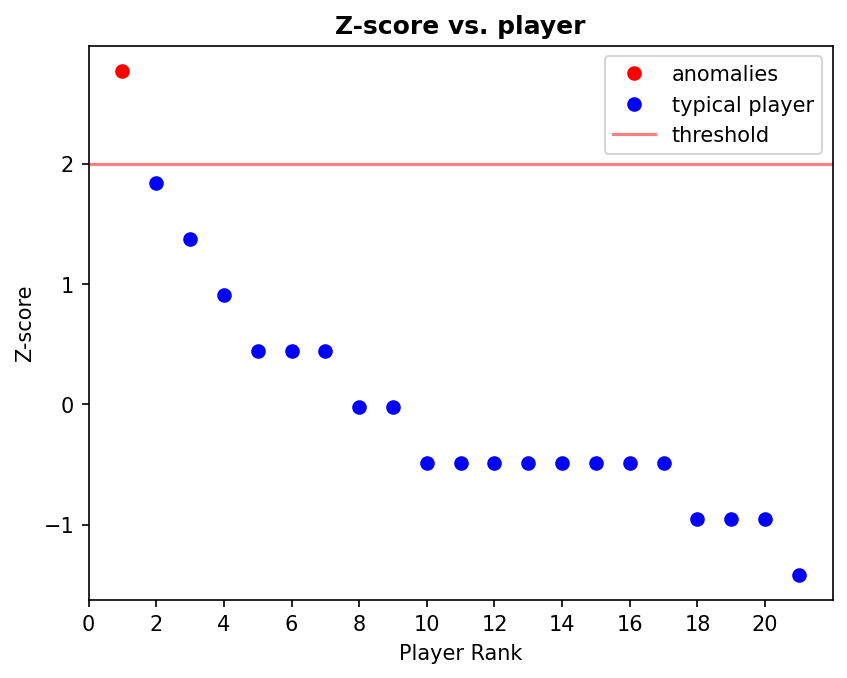

In [37]:
plot_anomaly_goals(top_goals['zscore'], 2)

Only one player is picked out: Just Fontaine. 

In [38]:
zscore_anomalies_players = top_goals[(top_goals['zscore'] > 2)]
zscore_anomalies_players

,Year,Player(s),Goals,zscore
5,1958,Just Fontaine,13,2.770264


Fontaine was indeed an amazing player, but clearly our analysis is flawed. By looking at the plot, we see that in 12 out of 21 competitions, the top goalscorer(s) scored less than the mean number of goals (7.05). 

**Question**: What's going on? 

**Answer**: We are seeing an effect we discussed in lectures---the mean and standard deviation are themselves susceptible to the presence of anomalies. With his 13 goals, the amazing Fontaine is raising the mean so much that most players fall below it. As a result, he becomes the only anomaly.

Let's repeat this analysis with the modified z-score and see what happens.

In [39]:
median_goals = np.median(top_goals['Goals'])
median_goals

6.0

Note that the median (6.0) is lower than the mean (7.05) as would be expected from the plot. 

Now calculate the modified z-score. Recall that in lectures this was defined for each data point $x_{i}$ as follows:

$y_{i} = (x_{i} - \tilde X)/{\rm MAD}$

where $\tilde X$ is the median of the data and MAD is the median of the absolute deviation from the median.

Here we are going to make a slight modification and introduce a consistency correction $k$, which allows us to use MAD as a consistent estimate for the standard deviation. The value of $k$ depends on the underlying distribution of the data. For simplicity, we will use the value for a normal distribution $k=1.4826$ (see [https://en.wikipedia.org/wiki/Median_absolute_deviation](https://en.wikipedia.org/wiki/Median_absolute_deviation)).

**Note:** Correction factor of $k=1.4826$ still assumes the underlying data is normal!

So the modified z-score becomes

$y_{i} = (x_{i} - \tilde X)/(k*{\rm MAD})$

and this is the form we will use in the function below.

In [40]:
def modified_zscore(data, consistency_correction=1.4826):
    """
    Returns the modified z score and Median Absolute Deviation (MAD) from the scores in data.
    The consistency_correction factor converts the MAD to the standard deviation for a given
    distribution. The default value (1.4826) is the conversion factor if the underlying data
    is normally distributed
    """
    median = np.median(data)
    
    deviation_from_med = np.array(data) - median

    mad = np.median(np.abs(deviation_from_med))
    mod_zscore = deviation_from_med/(consistency_correction*mad)
    return mod_zscore, mad

As before, compute the modified z-score for all players then plot and list the results. Note that the threshold remains the same at $y = +2$.

In [46]:
mod_zscore_goals, mad_goals = modified_zscore(top_goals['Goals'])
top_goals = top_goals.assign(mod_zscore=mod_zscore_goals)
top_goals.head()

,Year,Player(s),Goals,zscore,mod_zscore
0,1930,Guillermo Stábile,8,0.443242,1.348982
1,1934,Oldřich Nejedlý,5,-0.952971,-0.674491
2,1938,Leônidas,7,-0.022162,0.674491
3,1950,Ademir,8,0.443242,1.348982
4,1954,Sándor Kocsis,11,1.839455,3.372454


In [42]:
def plot_anomaly_goals_2(score_data, threshold):
    score_data = score_data.copy().sort_values(ascending=False).values
    ranks = np.linspace(1, len(score_data), len(score_data))
    mask_outliers = (score_data > threshold)
    
    plt.figure(dpi=150)
    plt.plot(ranks[mask_outliers], score_data[mask_outliers],'o', color='r',label='anomalies')
    plt.plot(ranks[~mask_outliers], score_data[~mask_outliers],'o', color='b', label='typical player')
    plt.axhline(threshold,color='r',label='threshold', alpha=0.5)
    plt.legend(loc = 'upper right')
    plt.title('Modified z-score vs. player', fontweight='bold')
    plt.xticks(np.arange(0, 21, step=2.0))
    plt.xlabel('Player')
    plt.ylabel('Modified z-score')
    plt.show()

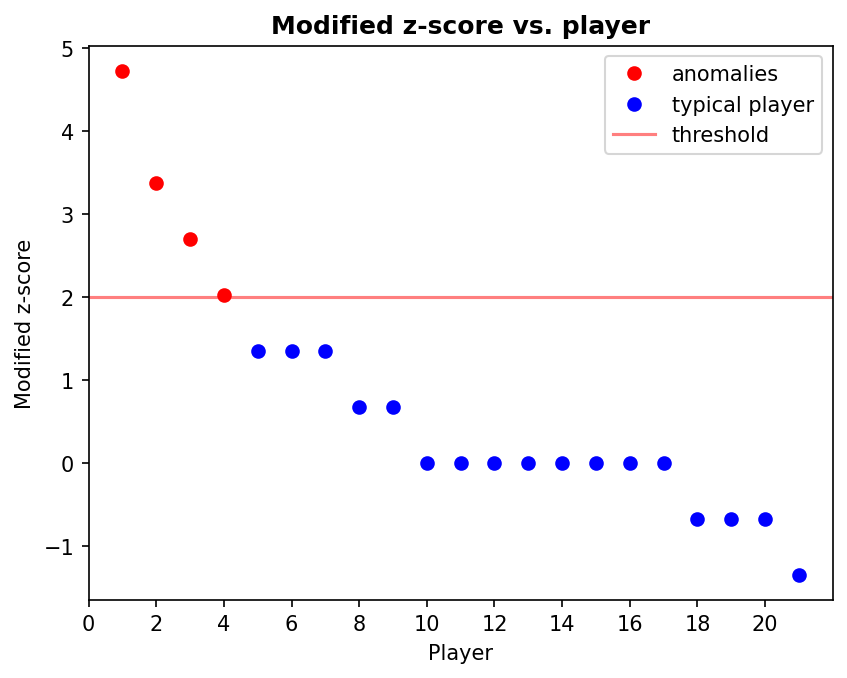

In [43]:
plot_anomaly_goals_2(top_goals['mod_zscore'], 2)

In [44]:
mod_zscore_anomalies_players = top_goals[(top_goals['mod_zscore'] > 2)]
mod_zscore_anomalies_players

,Year,Player(s),Goals,zscore,mod_zscore
4,1954,Sándor Kocsis,11,1.839455,3.372454
5,1958,Just Fontaine,13,2.770264,4.721435
7,1966,Eusébio,9,0.908647,2.023472
8,1970,Gerd Müller,10,1.374051,2.697963


Now we find four anomalous players.

**Question:** How does the MAD compare with the standard deviation calculated previously?

**Answer:** 

In [45]:
print('The value of MAD is {:.2f}'.format(mad_goals))

The value of MAD is 1.00


and $k*{\rm MAD}$ is 1.48, which is smaller than the standard deviation (2.05). We see that the anomalies have a larger effect on the standard deviation, which depends on the square of the deviation from the mean (MAD depends linearly on the deviation).

Of course, the data for top goal scorers is not normally distributed, so we can't associated probabilities with our scores, but our analysis does show the need to think about the scoring method used with the data.

# Summary

In this assignment you should have learned: 
1. How anomaly detection can be implemented as an algorithm
2. The importance of chosing an appropriate model and anomaly score
3. Some practical experience in using z-score and modified z-score in anomaly detection

Congratulations! This concludes the lesson.